데이터세트 일부 처리


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


#드라이브 내 데이터 셋 존재하는 폴더로 이동(드라이브 경로)

In [ ]:
cd /content/drive/MyDrive/python_API_Programming_2022/bigdata_practice

/content/drive/MyDrive/python_API_Programming_2022/bigdata_practice


In [ ]:
import pandas as pd #Analysis 
import matplotlib.pyplot as plt #Visulization
import seaborn as sns #Visulization
import numpy as np #Analysis 
from scipy.stats import norm #Analysis 
from sklearn.preprocessing import StandardScaler #Analysis 
from scipy import stats #Analysis 
import warnings 
warnings.filterwarnings('ignore')
%matplotlib inline

from sklearn.model_selection import KFold
import sklearn.model_selection
from sklearn.metrics import mean_absolute_error
import gc
import lightgbm as lgb

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import BayesianRidge


In [ ]:
train_df = pd.read_csv('train_seoul_3th.csv',encoding='UTF-8')


##if : data == xlxs
#train_df = pd.read_excel('train_seoul_3th.xlsx')

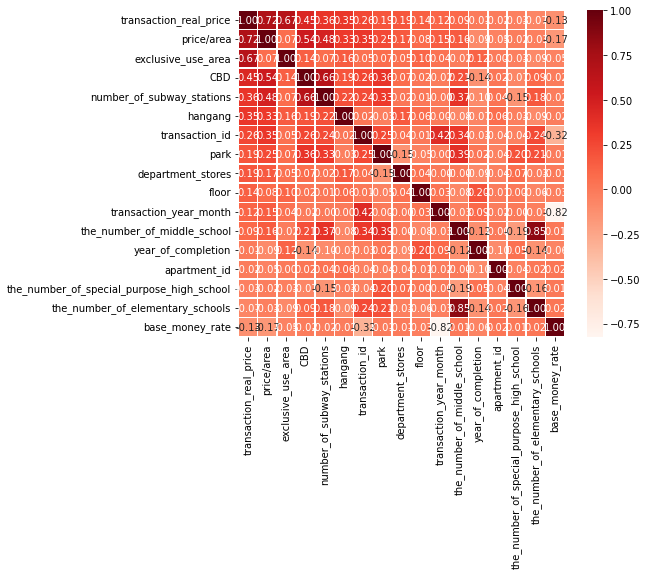

In [ ]:
#상관관계 확인
k=train_df.shape[1] #히트맵 변수 갯수
corrmat = train_df.corr() #변수간의 상관관계
cols = corrmat.nlargest(k, 'transaction_real_price')['transaction_real_price'].index #price기준으로 제일 큰순서대로 20개를 뽑아냄
cm = np.corrcoef(train_df[cols].values.T)
f, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(data = cm, annot=True, square=True, fmt = '.2f', linewidths=.5, cmap='Reds', 
            yticklabels = cols.values, xticklabels = cols.values)

In [ ]:
train_df['floor'].astype(int)
train_df['transaction_real_price'].astype(int)




train_dong = train_df[['transaction_real_price','dong']].groupby('dong').mean().sort_values('transaction_real_price').reset_index()

dong_num = {}
for i in range(len(train_dong)):
    dong = train_dong['dong'].iloc[i]
    dong_num[dong] = i
    



train_set,test_set = sklearn.model_selection.train_test_split(train_df,random_state=40)

train_set = train_set.replace({'dong' : dong_num})
test_set = test_set.replace({'dong' : dong_num})


train_jibun = train_set[['transaction_real_price','jibun']].groupby('jibun').mean().sort_values('transaction_real_price').reset_index()
train_set['day_diff'] = train_set['transaction_date'].str.extract('(~\d+)')[0].str[1:].astype(int) - train_set['transaction_date'].str.extract('(\d+~)')[0].str[:-1].astype(int)
test_set['day_diff'] = test_set['transaction_date'].str.extract('(~\d+)')[0].str[1:].astype(int) - test_set['transaction_date'].str.extract('(\d+~)')[0].str[:-1].astype(int)

train_date = train_set[['transaction_real_price','transaction_date']].groupby('transaction_date').mean().sort_values('transaction_real_price').reset_index()

date_num = {}
for i in range(len(train_date)):
    date = train_date['transaction_date'].iloc[i]
    date_num[date] = i
    
train_set = train_set.replace({'transaction_date' : date_num})
test_set = test_set.replace({'transaction_date' : date_num})


train_test_data = [train_set, test_set]

for dataset in train_test_data:
    #date -> 년, 월 단위로 새로운 칼럼 만듦
    dataset['transaction_year_month'] = dataset['transaction_year_month'].astype(str)
    dataset['year'] = dataset['transaction_year_month'].str[:4].astype(int)
    dataset['month'] = dataset['transaction_year_month'].str[4:6].astype(int)
    dataset['transaction_year_month'] = dataset['transaction_year_month'].astype(int)


train_test_data = [train_set, test_set]

for dataset in train_test_data:
    # 거래하는 기간까지의 아파트 나이를 feature 생성
    dataset['age'] = dataset['year'] - dataset['year_of_completion']
    # 샘플코드에 있는 아파트의 재건축 유무를 판단하는 feature 생성
    dataset['is_rebuild']=(dataset['age']>=30).astype(int)


train_set=train_set.drop(labels=['apt','addr_kr','jibun','address_gu'],axis=1)
test_set=test_set.drop(labels=['apt','addr_kr','jibun','address_gu'],axis=1)
train_set['floor'].loc[train_set['floor']<0]=0


train_set['special_high_school'] = train_set['the_number_of_special_purpose_high_school']
train_set['middle_school'] = train_set['the_number_of_middle_school']
train_set['elementary_schools'] = train_set['the_number_of_elementary_schools']
train_set=train_set.drop(labels=['the_number_of_special_purpose_high_school','the_number_of_middle_school','the_number_of_elementary_schools'],axis=1)

test_set['special_high_school'] = test_set['the_number_of_special_purpose_high_school']
test_set['middle_school'] = test_set['the_number_of_middle_school']
test_set['elementary_schools'] = test_set['the_number_of_elementary_schools']
test_set=test_set.drop(labels=['the_number_of_special_purpose_high_school','the_number_of_middle_school','the_number_of_elementary_schools'],axis=1)

In [ ]:
#train_set=train_set.drop(labels=['special_high_school','middle_school','elementary_schools'],axis=1)\
#test_set=test_set.drop(labels=['special_high_school','middle_school','elementary_schools'],axis=1)

In [ ]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 556713 entries, 664659 to 473253
Data columns (total 24 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   transaction_id             556713 non-null  int64  
 1   apartment_id               556713 non-null  int64  
 2   dong                       556713 non-null  int64  
 3   exclusive_use_area         556713 non-null  float64
 4   year_of_completion         556713 non-null  int64  
 5   transaction_year_month     556713 non-null  int64  
 6   transaction_date           556713 non-null  int64  
 7   floor                      556713 non-null  int64  
 8   transaction_real_price     556713 non-null  int64  
 9   hangang                    556713 non-null  int64  
 10  CBD                        556713 non-null  int64  
 11  park                       556713 non-null  int64  
 12  price/area                 556713 non-null  float64
 13  base_money_rate         

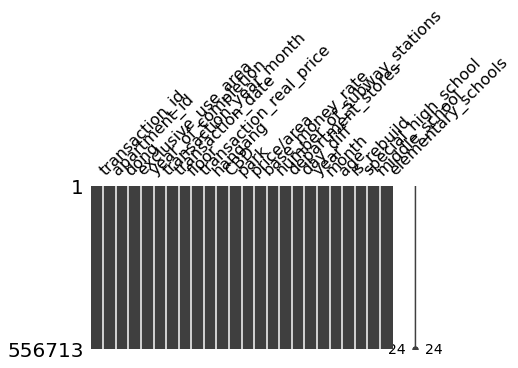

In [ ]:
import missingno as msno
msno.matrix(train_set,figsize=(6,3))

In [ ]:
train_set.head(40)

,transaction_id,apartment_id,dong,exclusive_use_area,year_of_completion,transaction_year_month,transaction_date,floor,transaction_real_price,hangang,...,number_of_subway_stations,department_stores,day_diff,year,month,age,is_rebuild,special_high_school,middle_school,elementary_schools
664659,1108337,854,55,59.9400,1989,201703,4,4,24800,0,...,8,0,10,2017,3,28,0,0,29,45
716127,1166447,9210,277,84.9820,2013,201710,3,10,93800,0,...,12,0,9,2017,10,4,0,0,32,43
192609,192609,1480,32,59.9580,2000,201011,3,1,23900,0,...,13,1,9,2010,11,10,0,0,39,65
161165,161165,6007,64,69.0300,1987,201308,4,11,23950,0,...,3,0,10,2013,8,26,0,1,39,65
7219,7219,12110,223,122.2750,1993,201201,2,3,42000,0,...,23,0,9,2012,1,19,0,1,25,39
434788,434788,7968,146,59.9000,1998,201405,2,10,28000,0,...,11,0,9,2014,5,16,0,0,35,68
241501,241501,9167,152,59.1700,2005,200803,3,4,19500,0,...,13,0,9,2008,3,3,0,0,46,71
433119,433119,10024,154,59.4000,1997,201312,2,23,30000,0,...,11,0,9,2013,12,16,0,0,35,68
51470,51470,1318,242,84.9100,1996,201212,4,3,44500,1,...,11,0,10,2012,12,16,0,2,23,43
670555,1114633,10103,128,84.9800,2006,201709,2,4,41500,0,...,9,0,9,2017,9,11,0,1,30,43


In [ ]:
train_set.columns

Index(['transaction_id', 'apartment_id', 'dong', 'exclusive_use_area',
       'year_of_completion', 'transaction_year_month', 'transaction_date',
       'floor', 'transaction_real_price', 'hangang', 'CBD', 'park',
       'price/area', 'base_money_rate', 'number_of_subway_stations',
       'department_stores', 'day_diff', 'year', 'month', 'age', 'is_rebuild',
       'special_high_school', 'middle_school', 'elementary_schools'],
      dtype='object')

In [ ]:
test_set.head(40)

,transaction_id,apartment_id,dong,exclusive_use_area,year_of_completion,transaction_year_month,transaction_date,floor,transaction_real_price,hangang,...,number_of_subway_stations,department_stores,day_diff,year,month,age,is_rebuild,special_high_school,middle_school,elementary_schools
220910,220910,5038,32,44.3300,1988,201503,2,12,15000,0,...,13,1,9,2015,3,27,0,0,39,65
321435,321435,4398,215,59.2900,1988,201401,2,4,36500,0,...,5,0,9,2014,1,26,0,0,41,65
406875,406875,4956,83,84.8960,2010,201609,5,1,38000,0,...,7,0,9,2016,9,6,0,1,35,68
143328,143328,3619,119,59.9900,2011,201509,3,3,36000,0,...,3,1,9,2015,9,4,0,0,30,43
634387,634387,6467,226,59.6400,2000,201312,4,9,34300,1,...,14,0,10,2013,12,13,0,0,48,70
460637,460637,5025,211,84.9500,1998,201408,4,19,39000,0,...,12,0,10,2014,8,16,0,0,32,43
295315,295315,6033,261,84.9800,2010,201501,3,14,55700,1,...,16,0,9,2015,1,5,0,0,46,71
78225,78225,10222,126,19.5250,2012,201606,2,10,13200,0,...,6,0,9,2016,6,4,0,0,29,45
639547,639547,684,161,59.8700,2009,201501,3,4,38500,0,...,14,0,9,2015,1,6,0,0,48,70
57684,57684,1472,269,75.5500,1989,201606,3,1,55000,1,...,11,0,9,2016,6,27,0,2,23,43


In [ ]:
train_columns = []
for column in train_set.columns[:]:
    if train_set[column].skew() >= 1:
        print("%s -> Skewness: %f, Kurtosis: %f" %  (column,train_set[column].skew(), 
                                                 train_set[column].kurt()))
        train_columns.append(column)
    elif train_set[column].kurt() >= 3:
        print("%s -> Skewness: %f, Kurtosis: %f" %  (column,train_set[column].skew(), 
                                                 train_set[column].kurt()))
        train_columns.append(column)

transaction_id -> Skewness: 1.069116, Kurtosis: 0.460242
exclusive_use_area -> Skewness: 1.263251, Kurtosis: 3.750259
floor -> Skewness: 1.099613, Kurtosis: 2.415969
transaction_real_price -> Skewness: 3.387024, Kurtosis: 23.486711
hangang -> Skewness: 2.254406, Kurtosis: 3.082355
CBD -> Skewness: 1.167436, Kurtosis: -0.637095
price/area -> Skewness: 2.007684, Kurtosis: 5.696937
base_money_rate -> Skewness: 1.543407, Kurtosis: 2.146340
department_stores -> Skewness: 1.872658, Kurtosis: 2.357890
day_diff -> Skewness: -0.600418, Kurtosis: 4.514374
is_rebuild -> Skewness: 3.181670, Kurtosis: 8.123054
special_high_school -> Skewness: 1.224228, Kurtosis: 0.336852


In [ ]:
train_columns

['transaction_id',
 'exclusive_use_area',
 'floor',
 'transaction_real_price',
 'hangang',
 'CBD',
 'price/area',
 'base_money_rate',
 'department_stores',
 'day_diff',
 'is_rebuild',
 'special_high_school']

In [ ]:
for column in train_columns :
    train_set[column] = np.log1p(train_set[column])
    test_set[column] = np.log1p(test_set[column])
    print("%s -> Skewness: %f, Kurtosis: %f" %  (column,train_set[column].skew(), 
                                                 train_set[column].kurt()))

transaction_id -> Skewness: -1.597564, Kurtosis: 4.575699
exclusive_use_area -> Skewness: -0.590381, Kurtosis: 2.305678
floor -> Skewness: -0.402609, Kurtosis: -0.531463
transaction_real_price -> Skewness: 0.356755, Kurtosis: 0.587102
hangang -> Skewness: 2.254406, Kurtosis: 3.082355
CBD -> Skewness: 1.167436, Kurtosis: -0.637095
price/area -> Skewness: 0.631737, Kurtosis: 0.747074
base_money_rate -> Skewness: 0.846287, Kurtosis: 0.232532
department_stores -> Skewness: 1.705804, Kurtosis: 1.127075
day_diff -> Skewness: -1.135047, Kurtosis: 6.704011
is_rebuild -> Skewness: 3.181670, Kurtosis: 8.123054
special_high_school -> Skewness: 0.902770, Kurtosis: -0.793871


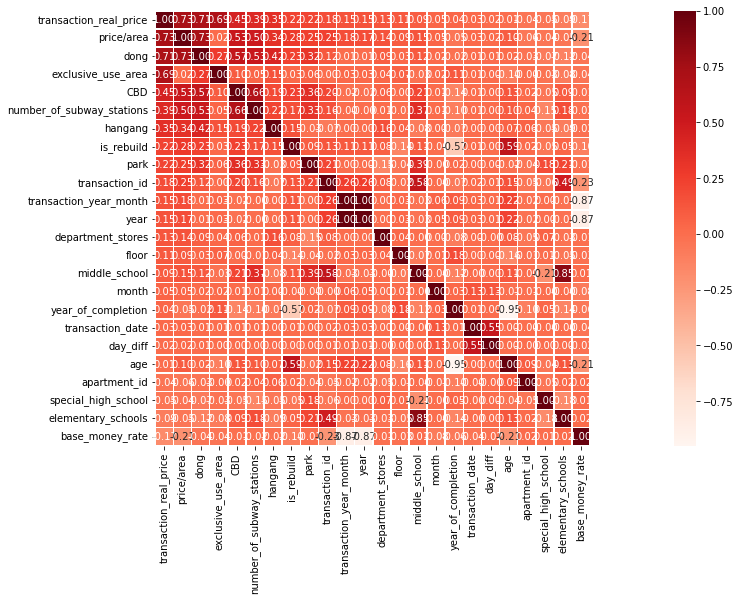

In [ ]:
#상관관계 확인
k=train_set.shape[1] #히트맵 변수 갯수
corrmat = train_set.corr() #변수간의 상관관계
cols = corrmat.nlargest(k, 'transaction_real_price')['transaction_real_price'].index #price기준으로 제일 큰순서대로 20개를 뽑아냄
cm = np.corrcoef(train_set[cols].values.T)
f, ax = plt.subplots(figsize=(30, 8))
sns.heatmap(data = cm, annot=True, square=True, fmt = '.2f', linewidths=.5, cmap='Reds', 
            yticklabels = cols.values, xticklabels = cols.values)

In [ ]:
train_set

,transaction_id,apartment_id,dong,exclusive_use_area,year_of_completion,transaction_year_month,transaction_date,floor,transaction_real_price,hangang,...,number_of_subway_stations,department_stores,day_diff,year,month,age,is_rebuild,special_high_school,middle_school,elementary_schools
664659,13.918372,854,55,4.109890,1989,201703,4,1.609438,10.118639,0.0,...,8,0.000000,2.397895,2017,3,28,0.0,0.000000,29,45
716127,13.969474,9210,277,4.454138,2013,201710,3,2.397895,11.448931,0.0,...,12,0.000000,2.302585,2017,10,4,0.0,0.000000,32,43
192609,12.168423,1480,32,4.110185,2000,201011,3,0.693147,10.081676,0.0,...,13,0.693147,2.302585,2010,11,10,0.0,0.000000,39,65
161165,11.990190,6007,64,4.248924,1987,201308,4,2.484907,10.083765,0.0,...,3,0.000000,2.397895,2013,8,26,0.0,0.693147,39,65
7219,8.884610,12110,223,4.814418,1993,201201,2,1.386294,10.645449,0.0,...,23,0.000000,2.302585,2012,1,19,0.0,0.693147,25,39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200211,12.207132,8881,44,4.107425,2004,201205,2,1.945910,10.196194,0.0,...,13,0.000000,2.302585,2012,5,8,0.0,0.000000,39,65
137031,11.827970,8031,119,4.110546,2004,201104,3,2.197225,10.203629,0.0,...,3,0.693147,2.302585,2011,4,7,0.0,0.000000,30,43
666892,13.920517,10029,46,4.633369,1995,201711,3,1.791759,10.778977,0.0,...,8,0.000000,2.302585,2017,11,22,0.0,0.000000,29,45
114369,11.647194,1760,176,4.453649,2010,201302,1,2.079442,10.789340,0.0,...,9,0.693147,2.079442,2013,2,3,0.0,0.693147,30,43


### RMSE 부분 에러가능성 있습니다 
### 변수는 LBGM 실습 코드 기준 작성되었습니다.
-호윤

In [ ]:
!pip install optuna

     |████████████████████████████████| 308 kB 5.3 MB/s 
     |████████████████████████████████| 210 kB 46.4 MB/s 
     |████████████████████████████████| 81 kB 3.9 MB/s 
     |████████████████████████████████| 78 kB 6.0 MB/s 
     |████████████████████████████████| 49 kB 5.5 MB/s 
     |████████████████████████████████| 112 kB 44.1 MB/s 
     |████████████████████████████████| 146 kB 52.0 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=c4cb67b2f5c4846a0966d3e203fb3fb4356e42773cf5881c8e64e18b1fbaa212
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import  LabelEncoder
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb
import re
import optuna
from optuna.integration import XGBoostPruningCallback
sns.set_theme(style="darkgrid")


In [ ]:
train_X, train_y = train_set.drop('transaction_real_price', axis=1), train_set['transaction_real_price']
print(train_X.shape, train_y.shape)



(556713, 23) (556713,)


In [ ]:

def RMSE(y, y_pred):
    rmse = mean_squared_error(y, y_pred) ** 0.5
    return rmse

def rmse_cv(model):
    # cv별로 학습하는 함수
    tscv = TimeSeriesSplit(n_splits=10)
    rmse_list = []
    model_name = model.__class__.__name__
    for _, (train_index, test_index) in tqdm(enumerate(tscv.split(train_X), start=1), desc=f'{model_name} Cross Validations...', total=10):
        X_train, X_test = train_X.iloc[train_index], train_X.iloc[test_index]
        y_train, y_test = train_y.iloc[train_index], train_y.iloc[test_index]
        clf = model.fit(X_train, y_train)
        pred = clf.predict(X_test)
        rmse = RMSE(y_test, pred) 
        rmse_list.append(rmse)
    return model_name, rmse_list

def print_rmse_score(model):
    # cv별 프린팅, 평균 저장
    model_name, score = rmse_cv(model)
    for i, r in enumerate(score, start=1):
        print(f'{i} FOLDS: {model_name} RMSLE: {r:.4f}')
    print(f'\n{model_name} mean RMSLE: {np.mean(score):.4f}')
    print('='*40)
    return model_name, np.mean(score)

In [ ]:
reg = LinearRegression(n_jobs=-1)
ridge = Ridge(alpha=0.8, random_state=1)
lasso = Lasso(alpha = 0.01, random_state=1)
Enet = ElasticNet(alpha=0.03, l1_ratio=0.01, random_state=1)
DTree = DecisionTreeRegressor(max_depth=6, min_samples_split=10, min_samples_leaf=15, random_state=1)
rf = RandomForestRegressor(n_estimators=500, criterion='mse', max_depth=9, min_samples_split=50,
                           min_samples_leaf=5, random_state=1, n_jobs=-1)
model_xgb = xgb.XGBRegressor(n_estimators=500, max_depth=9, min_child_weight=5, gamma=0.1, n_jobs=-1)
model_lgb = lgb.LGBMRegressor(n_estimators=500, max_depth=9, min_child_weight=5, n_jobs=-1)

In [ ]:
models = []
scores = []
for model in [reg, ridge, lasso, Enet, DTree, rf, model_xgb, model_lgb]:
    model_name, mean_score = print_rmse_score(model)
    models.append(model_name)
    scores.append(mean_score)

LinearRegression Cross Validations...: 100%|██████████| 10/10 [00:05<00:00,  1.98it/s]


1 FOLDS: LinearRegression RMSLE: 0.0209
2 FOLDS: LinearRegression RMSLE: 0.0155
3 FOLDS: LinearRegression RMSLE: 0.0157
4 FOLDS: LinearRegression RMSLE: 0.0188
5 FOLDS: LinearRegression RMSLE: 0.0179
6 FOLDS: LinearRegression RMSLE: 0.0212
7 FOLDS: LinearRegression RMSLE: 0.0171
8 FOLDS: LinearRegression RMSLE: 0.0171
9 FOLDS: LinearRegression RMSLE: 0.0172
10 FOLDS: LinearRegression RMSLE: 0.0165

LinearRegression mean RMSLE: 0.0178


Ridge Cross Validations...: 100%|██████████| 10/10 [00:02<00:00,  3.68it/s]


1 FOLDS: Ridge RMSLE: 0.0209
2 FOLDS: Ridge RMSLE: 0.0155
3 FOLDS: Ridge RMSLE: 0.0157
4 FOLDS: Ridge RMSLE: 0.0188
5 FOLDS: Ridge RMSLE: 0.0179
6 FOLDS: Ridge RMSLE: 0.0212
7 FOLDS: Ridge RMSLE: 0.0171
8 FOLDS: Ridge RMSLE: 0.0171
9 FOLDS: Ridge RMSLE: 0.0172
10 FOLDS: Ridge RMSLE: 0.0165

Ridge mean RMSLE: 0.0178


Lasso Cross Validations...: 100%|██████████| 10/10 [00:08<00:00,  1.19it/s]


1 FOLDS: Lasso RMSLE: 0.0598
2 FOLDS: Lasso RMSLE: 0.0582
3 FOLDS: Lasso RMSLE: 0.0579
4 FOLDS: Lasso RMSLE: 0.0590
5 FOLDS: Lasso RMSLE: 0.0591
6 FOLDS: Lasso RMSLE: 0.0593
7 FOLDS: Lasso RMSLE: 0.0591
8 FOLDS: Lasso RMSLE: 0.0580
9 FOLDS: Lasso RMSLE: 0.0588
10 FOLDS: Lasso RMSLE: 0.0588

Lasso mean RMSLE: 0.0588


ElasticNet Cross Validations...: 100%|██████████| 10/10 [04:29<00:00, 26.90s/it]


1 FOLDS: ElasticNet RMSLE: 0.1161
2 FOLDS: ElasticNet RMSLE: 0.1155
3 FOLDS: ElasticNet RMSLE: 0.1149
4 FOLDS: ElasticNet RMSLE: 0.1159
5 FOLDS: ElasticNet RMSLE: 0.1162
6 FOLDS: ElasticNet RMSLE: 0.1151
7 FOLDS: ElasticNet RMSLE: 0.1168
8 FOLDS: ElasticNet RMSLE: 0.1147
9 FOLDS: ElasticNet RMSLE: 0.1166
10 FOLDS: ElasticNet RMSLE: 0.1163

ElasticNet mean RMSLE: 0.1158


DecisionTreeRegressor Cross Validations...: 100%|██████████| 10/10 [00:21<00:00,  2.12s/it]


1 FOLDS: DecisionTreeRegressor RMSLE: 0.1148
2 FOLDS: DecisionTreeRegressor RMSLE: 0.1125
3 FOLDS: DecisionTreeRegressor RMSLE: 0.1139
4 FOLDS: DecisionTreeRegressor RMSLE: 0.1206
5 FOLDS: DecisionTreeRegressor RMSLE: 0.1116
6 FOLDS: DecisionTreeRegressor RMSLE: 0.1100
7 FOLDS: DecisionTreeRegressor RMSLE: 0.1121
8 FOLDS: DecisionTreeRegressor RMSLE: 0.1120
9 FOLDS: DecisionTreeRegressor RMSLE: 0.1117
10 FOLDS: DecisionTreeRegressor RMSLE: 0.1098

DecisionTreeRegressor mean RMSLE: 0.1129


RandomForestRegressor Cross Validations...: 100%|██████████| 10/10 [2:02:10<00:00, 733.10s/it] 


1 FOLDS: RandomForestRegressor RMSLE: 0.0420
2 FOLDS: RandomForestRegressor RMSLE: 0.0345
3 FOLDS: RandomForestRegressor RMSLE: 0.0350
4 FOLDS: RandomForestRegressor RMSLE: 0.0387
5 FOLDS: RandomForestRegressor RMSLE: 0.0325
6 FOLDS: RandomForestRegressor RMSLE: 0.0326
7 FOLDS: RandomForestRegressor RMSLE: 0.0342
8 FOLDS: RandomForestRegressor RMSLE: 0.0316
9 FOLDS: RandomForestRegressor RMSLE: 0.0319
10 FOLDS: RandomForestRegressor RMSLE: 0.0320

RandomForestRegressor mean RMSLE: 0.0345


XGBRegressor Cross Validations...:   0%|          | 0/10 [00:00<?, ?it/s]

[20:55:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor Cross Validations...:  10%|█         | 1/10 [00:45<06:53, 45.90s/it]

[20:56:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor Cross Validations...:  20%|██        | 2/10 [02:23<10:12, 76.57s/it]

[20:57:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor Cross Validations...:  30%|███       | 3/10 [05:08<13:36, 116.63s/it]

[21:00:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor Cross Validations...:  40%|████      | 4/10 [08:53<15:58, 159.71s/it]

[21:04:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor Cross Validations...:  50%|█████     | 5/10 [13:29<16:46, 201.32s/it]

[21:08:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor Cross Validations...:  60%|██████    | 6/10 [19:11<16:37, 249.42s/it]

[21:14:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor Cross Validations...:  70%|███████   | 7/10 [25:30<14:35, 291.76s/it]

[21:20:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor Cross Validations...:  80%|████████  | 8/10 [33:49<11:55, 357.71s/it]

[21:29:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor Cross Validations...:  90%|█████████ | 9/10 [42:14<06:43, 403.80s/it]

[21:37:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor Cross Validations...: 100%|██████████| 10/10 [52:27<00:00, 314.72s/it]


1 FOLDS: XGBRegressor RMSLE: 0.0299
2 FOLDS: XGBRegressor RMSLE: 0.0236
3 FOLDS: XGBRegressor RMSLE: 0.0224
4 FOLDS: XGBRegressor RMSLE: 0.0232
5 FOLDS: XGBRegressor RMSLE: 0.0208
6 FOLDS: XGBRegressor RMSLE: 0.0207
7 FOLDS: XGBRegressor RMSLE: 0.0201
8 FOLDS: XGBRegressor RMSLE: 0.0180
9 FOLDS: XGBRegressor RMSLE: 0.0181
10 FOLDS: XGBRegressor RMSLE: 0.0191

XGBRegressor mean RMSLE: 0.0216


LGBMRegressor Cross Validations...: 100%|██████████| 10/10 [02:04<00:00, 12.41s/it]

1 FOLDS: LGBMRegressor RMSLE: 0.0323
2 FOLDS: LGBMRegressor RMSLE: 0.0303
3 FOLDS: LGBMRegressor RMSLE: 0.0314
4 FOLDS: LGBMRegressor RMSLE: 0.0355
5 FOLDS: LGBMRegressor RMSLE: 0.0262
6 FOLDS: LGBMRegressor RMSLE: 0.0261
7 FOLDS: LGBMRegressor RMSLE: 0.0271
8 FOLDS: LGBMRegressor RMSLE: 0.0239
9 FOLDS: LGBMRegressor RMSLE: 0.0257
10 FOLDS: LGBMRegressor RMSLE: 0.0251

LGBMRegressor mean RMSLE: 0.0284


In [ ]:
result_df = pd.DataFrame({'Model': models, 'Score': scores}).reset_index(drop=True)
result_df

,Model,Score
0,LinearRegression,0.017799
1,Ridge,0.017800
2,Lasso,0.058792
3,ElasticNet,0.115799
4,DecisionTreeRegressor,0.112900
5,RandomForestRegressor,0.034481
6,XGBRegressor,0.021571
7,LGBMRegressor,0.028365


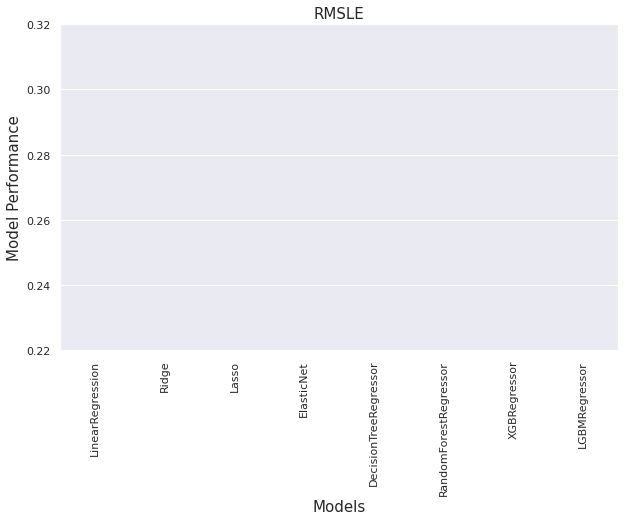

In [ ]:
f, ax = plt.subplots(figsize=(10, 6))
plt.xticks(rotation='90')
sns.barplot(x=result_df['Model'], y=result_df['Score'])
plt.xlabel('Models', fontsize=15)
plt.ylabel('Model Performance', fontsize=15)
plt.ylim(0.22, 0.32)
plt.title('RMSLE', fontsize=15)
plt.show()

Hyper parameter 튜닝

train데이터를 8:2 비율로 분할하여 학습, 검증에 사용
시계열 분석을 위해 데이터 섞이지 않도록 데이터의 마지막 20% 를 사용하게 된다

In [ ]:
cut = int(len(train_set)*0.8)
h_train = train_set[:cut]
h_valid = train_set[cut:]

h_train_X = h_train.drop('transaction_real_price', axis=1)
h_train_y = h_train['transaction_real_price']
h_valid_X = h_valid.drop('transaction_real_price', axis=1)
h_valid_y = h_valid['transaction_real_price']
print(h_train_X.shape, h_train_y.shape, h_valid_X.shape, h_valid_y.shape)

(445370, 23) (445370,) (111343, 23) (111343,)


In [ ]:
h_train_X.head()

,transaction_id,apartment_id,dong,exclusive_use_area,year_of_completion,transaction_year_month,transaction_date,floor,hangang,CBD,...,number_of_subway_stations,department_stores,day_diff,year,month,age,is_rebuild,special_high_school,middle_school,elementary_schools
664659,13.918372,854,55,4.109890,1989,201703,4,1.609438,0.0,0.000000,...,8,0.000000,2.397895,2017,3,28,0.0,0.000000,29,45
716127,13.969474,9210,277,4.454138,2013,201710,3,2.397895,0.0,0.000000,...,12,0.000000,2.302585,2017,10,4,0.0,0.000000,32,43
192609,12.168423,1480,32,4.110185,2000,201011,3,0.693147,0.0,0.000000,...,13,0.693147,2.302585,2010,11,10,0.0,0.000000,39,65
161165,11.990190,6007,64,4.248924,1987,201308,4,2.484907,0.0,0.000000,...,3,0.000000,2.397895,2013,8,26,0.0,0.693147,39,65
7219,8.884610,12110,223,4.814418,1993,201201,2,1.386294,0.0,0.693147,...,23,0.000000,2.302585,2012,1,19,0.0,0.693147,25,39


In [ ]:
start = timeit.default_timer()
cv_score(models)
stop = timeit.default_timer()
print('불러오는데 걸린 시간 : {}초'.format(stop - start))

NameError: ignored

In [ ]:
#여러개의 모델로 만들어진 predict 데이터들의 평균을 구한다.

models = [{'model':xgboost, 'name':'XGBoost'},
          {'model':lightgbm, 'name':'LightGBM'},
         {'model':forest, 'name' : 'RandomForest'}]

def AveragingBlending(models, x, y, sub_x):
    for m in models : 
        m['model'].fit(x.values, y)
    
    predictions = np.column_stack([m['model'].predict(sub_x.values) for m in models])
    return predictions

In [ ]:
start = timeit.default_timer()

y_test_pred = AveragingBlending(models, train, target, test)
y_test_pred = (y_test_pred[:, 0]*0.05 + y_test_pred[:, 1]*0.1 + y_test_pred[:, 2]*0.85)
predictions = y_test_pred

stop = timeit.default_timer()
print('불러오는데 걸린 시간 : {}초'.format(stop - start))